In [12]:
import os
import re
from typing import List, Optional

import click
import dnnlib
import numpy as np
import torch

import legacy

import librosa
import librosa.display

import noisereduce as nr

from tifresi.utils import load_signal
from tifresi.utils import preprocess_signal
from tifresi.hparams import HParams
from tifresi.stft import GaussTF, GaussTruncTF
from tifresi.transforms import log_spectrogram
from tifresi.transforms import inv_log_spectrogram

import matplotlib.pyplot as plt
np.seterr(divide='ignore', invalid='ignore')
import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)

from IPython.display import Audio 
import IPython

# import torchaudio

from torch_utils import misc 
import dnnlib


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
def pghi_stft(x):
        use_truncated_window = True
        if use_truncated_window:
            stft_system = GaussTruncTF(hop_size=hop_size, stft_channels=stft_channels)
        else:
            stft_system = GaussTF(hop_size=hop_size, stft_channels=stft_channels)
        Y = stft_system.spectrogram(x)
        log_Y= log_spectrogram(Y)
        return np.expand_dims(log_Y,axis=0)

In [14]:
def pghi_istft(x):
    use_truncated_window = True
    if use_truncated_window:
        stft_system = GaussTruncTF(hop_size=hop_size, stft_channels=stft_channels)
    else:
        stft_system = GaussTF(hop_size=hop_size, stft_channels=stft_channels)

    x = np.squeeze(x,axis=0)
    new_Y = inv_log_spectrogram(x)
    new_y = stft_system.invert_spectrogram(new_Y)
    return new_y

In [15]:
def zeropad(signal, audio_length):
        if len(signal) < audio_length:
            return np.append(
                signal, 
                np.zeros(audio_length - len(signal))
            )
        else:
            signal = signal[0:audio_length]
            return signal

In [16]:
def rms_normalize(y, rms_level=-10):
    """
    Normalize the signal given a certain technique (peak or rms).
    Args:
        - infile    (str) : input filename/path.
        - rms_level (int) : rms level in dB.
    """

    # linear rms level and scaling factor
    r = 10**(rms_level / 10.0)
    a = np.sqrt( (len(y) * r**2) / np.sum(y**2) )

    # normalize
    y = y * a
    return y

In [17]:
sample_rate = 16000
stft_channels = 512 #510
n_frames = 256
hop_size = 128
sample_rate = 16000
n_bins = int(512 / 2)+1

In [18]:
def display_audio_stats(audio_file, name='', start_sec=0, end_sec=None, reduce_noise=False):
    with open(audio_file, 'rb') as f:
        y, sr = load_signal(f, sr=sample_rate)
        print('original length of audio = ', len(y))
        if end_sec is None:
            end_sec = len(y)/sample_rate
        y = y[int(start_sec*sample_rate):int(end_sec*sample_rate)]
        
        if reduce_noise:
            y = nr.reduce_noise(y=y, sr=sample_rate)
        
        print('Length of audio for stft = ', len(y))
        fig, axs = plt.subplots(ncols=4, figsize=(18,5))
        
        axs[0].plot(y)
        axs[0].set_title(name)
        IPython.display.display(IPython.display.Audio(y, rate=sample_rate))

        y = preprocess_signal(y)
        y = zeropad(y, n_frames * hop_size )
        y = pghi_stft(y)
        
        axs[1].set_title(name + ' PGHI values histogram')
        axs[1].hist(y[0].flatten())
        
        a=librosa.display.specshow(y[0],x_axis='time', y_axis='log', ax=axs[2], sr=sample_rate, hop_length=hop_size)
        axs[2].set_title('PGHI stft')
        
        axs[3].imshow(y[0])
        print(y.shape)

# Tok-Wotel

original length of audio =  32000
Length of audio for stft =  32000


(1, 257, 256)


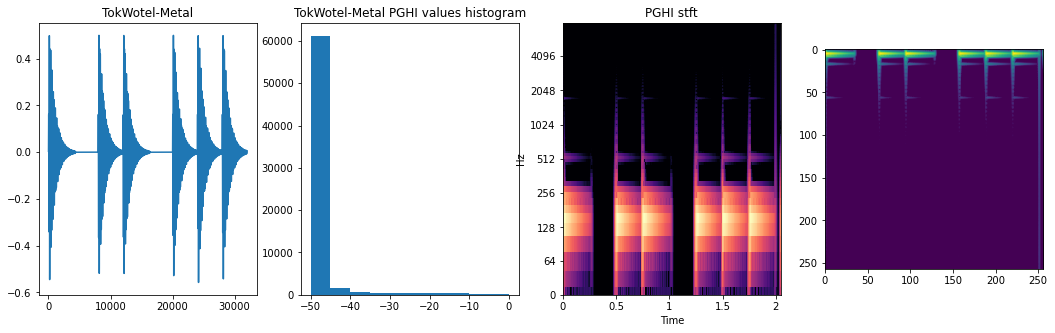

In [19]:
audio_file = 'datasets/tokwotel/00000/TokWotalDuet--hitratio-00.00--wmratio-01.00--rate_exp-00.50--v-04.wav'
display_audio_stats(audio_file, 'TokWotel-Metal', reduce_noise=False)

original length of audio =  32000
Length of audio for stft =  32000


(1, 257, 256)


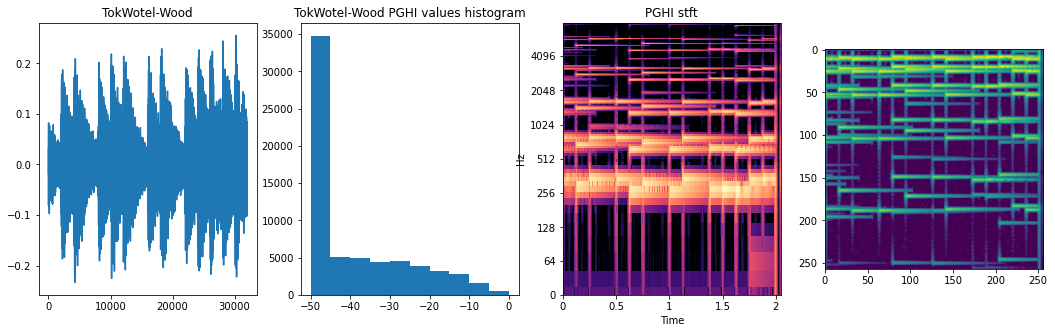

In [10]:
audio_file = 'datasets/tokwotel/00000/TokWotalDuet--hitratio-00.00--wmratio-00.00--rate_exp-01.00--v-01.wav'
display_audio_stats(audio_file, 'TokWotel-Wood')

# CMU Dataset

original length of audio =  139134
Length of audio for stft =  32000


(1, 257, 256)
original length of audio =  139134
Length of audio for stft =  32000


(1, 257, 256)


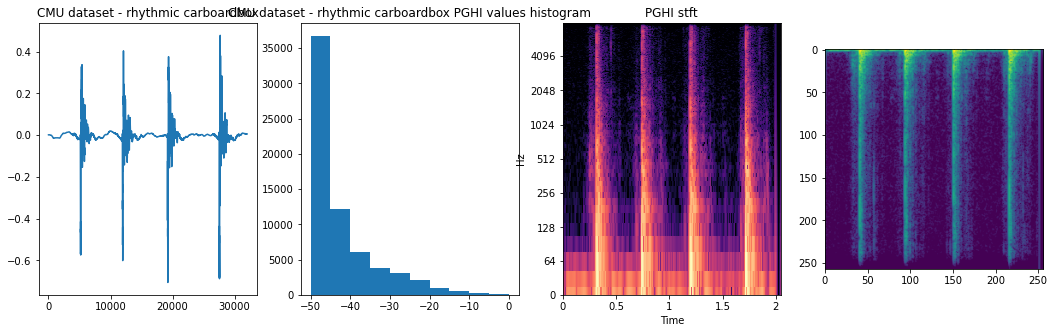

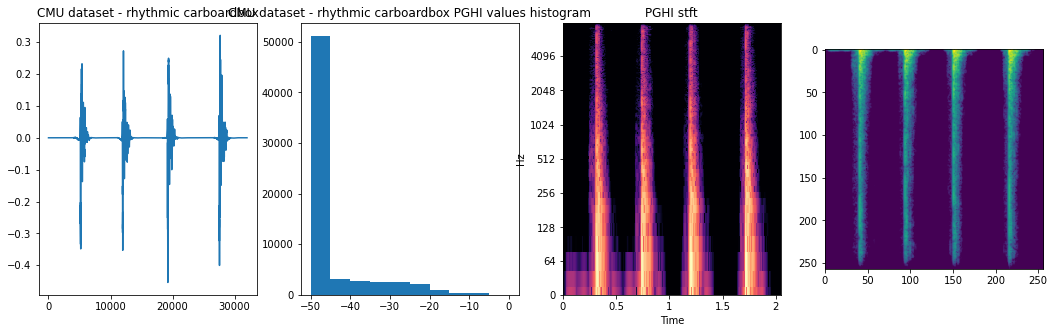

In [11]:
audio_file = '/home/purnima/appdir/Github/DATA/CMU-EventsDB-HellerLab/impact-sounds/Impacts_audio1/Cardboard Boxes/rhythmic-hittingcardboardboxtogeth.wav'
display_audio_stats(audio_file, 'CMU dataset - rhythmic carboardbox', start_sec=3.4, end_sec=5.4)

display_audio_stats(audio_file, 'CMU dataset - rhythmic carboardbox', start_sec=3.4, end_sec=5.4, reduce_noise=True)

original length of audio =  50156
Length of audio for stft =  32000


(1, 257, 256)
original length of audio =  50156
Length of audio for stft =  32000


(1, 257, 256)


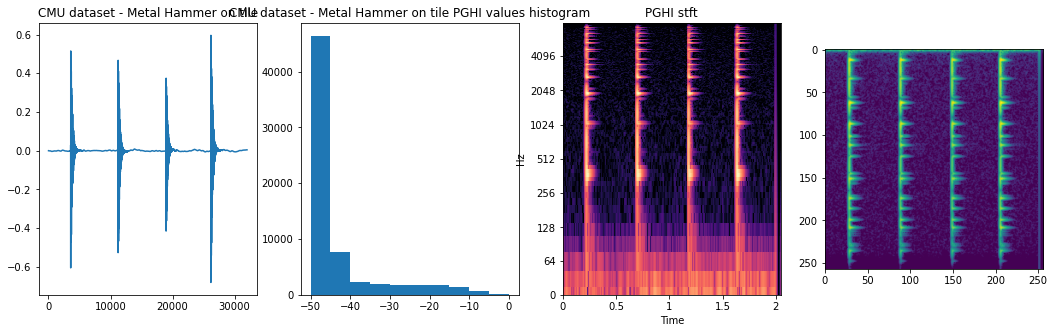

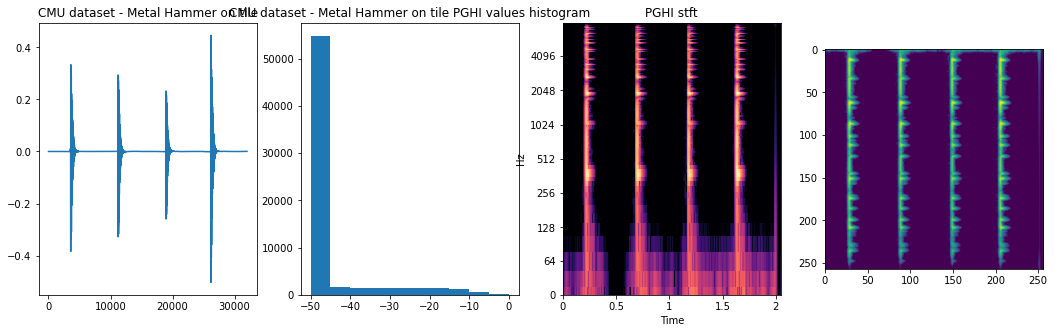

In [12]:
audio_file = '/home/purnima/appdir/Github/DATA/CMU-EventsDB-HellerLab/impact-sounds/Impacts_audio1/Hammer on Tile/metaLhammer_ceramictile.wav'
display_audio_stats(audio_file, 'CMU dataset - Metal Hammer on tile', start_sec=0, end_sec=2)

display_audio_stats(audio_file, 'CMU dataset - Metal Hammer on tile', start_sec=0, end_sec=2, reduce_noise=True)

original length of audio =  175779
Length of audio for stft =  159779


(1, 257, 256)
original length of audio =  175779
Length of audio for stft =  159779


(1, 257, 256)


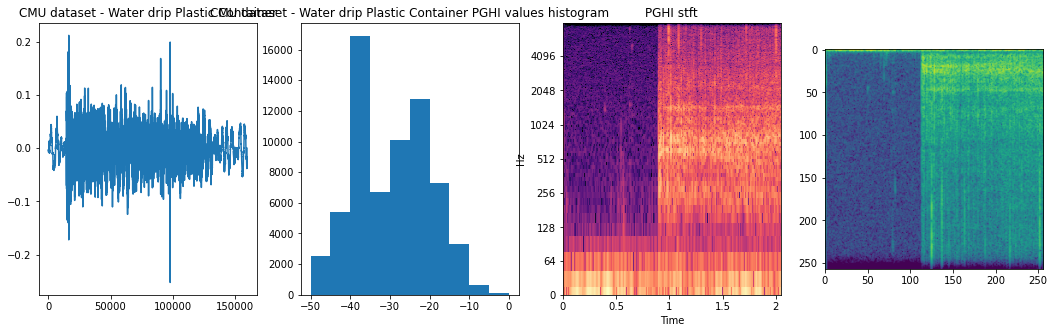

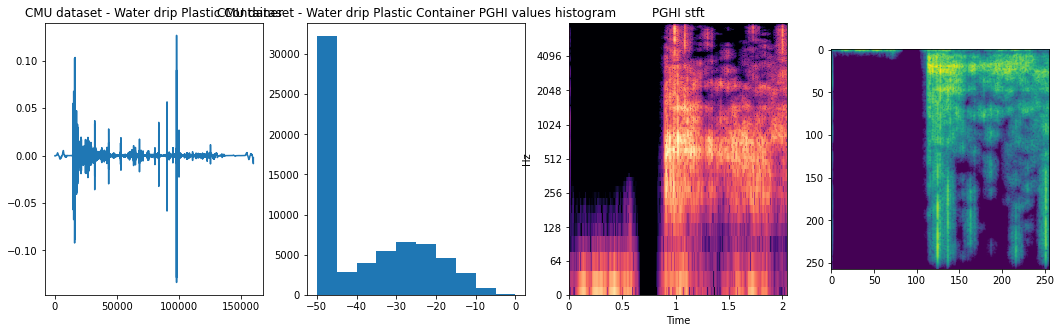

In [13]:
audio_file = '/home/purnima/appdir/Github/DATA/CMU-EventsDB-HellerLab/liquid-events/dripping/Drip_audio1/Watering Can to Empty Tupperwar/dripsfromwateringcanintoemp.4'
display_audio_stats(audio_file, 'CMU dataset - Water drip Plastic Container', start_sec=1, end_sec=None)

display_audio_stats(audio_file, 'CMU dataset - Water drip Plastic Container', start_sec=1, end_sec=None, reduce_noise=True)

original length of audio =  161699
Length of audio for stft =  129699


(1, 257, 256)
original length of audio =  161699
Length of audio for stft =  129699


(1, 257, 256)


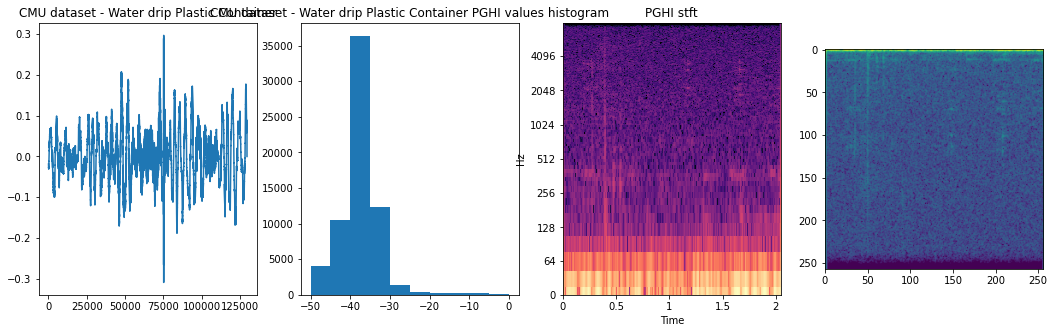

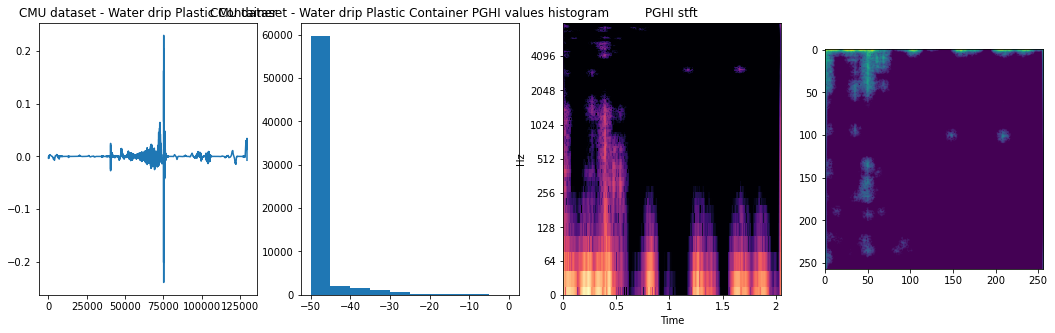

In [14]:
audio_file = '/home/purnima/appdir/Github/DATA/CMU-EventsDB-HellerLab/rolling-events/Rolls_audio1/Can on Metal/rollingsodacanmetal-4.wav'
display_audio_stats(audio_file, 'CMU dataset - Water drip Plastic Container', start_sec=2, end_sec=None)

display_audio_stats(audio_file, 'CMU dataset - Water drip Plastic Container', start_sec=2, end_sec=None, reduce_noise=True)

original length of audio =  191181
Length of audio for stft =  80000


(1, 257, 256)
original length of audio =  191181
Length of audio for stft =  80000


(1, 257, 256)


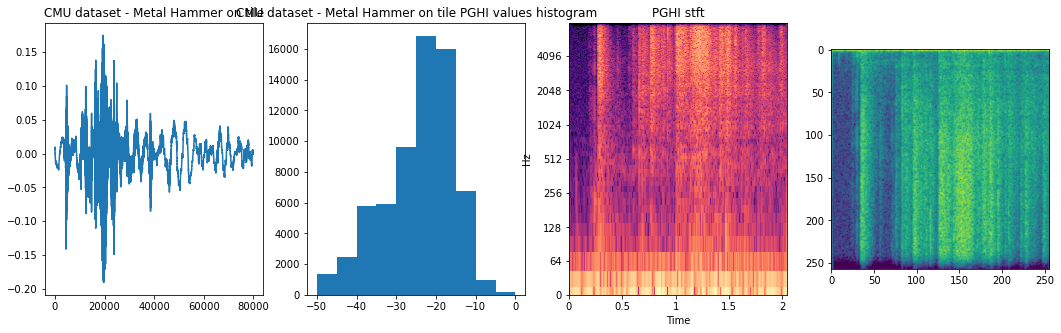

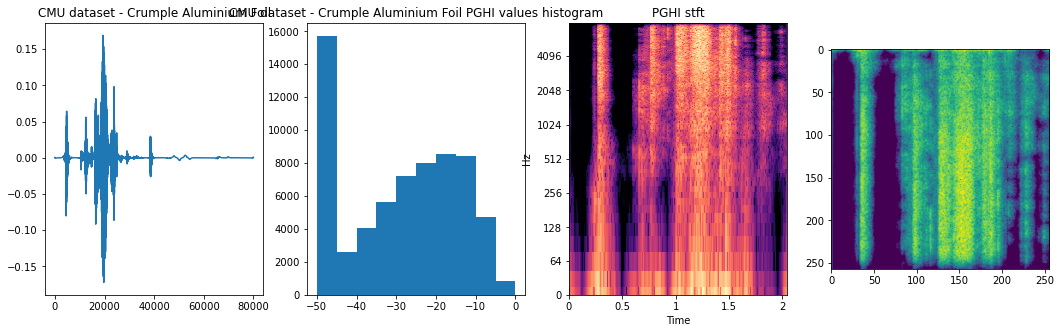

In [15]:
audio_file = '/home/purnima/appdir/Github/DATA/CMU-EventsDB-HellerLab/deformation-events/Deformations_audio1/Crumple Aluminum Foil/AlFoilCrumple.wav'
display_audio_stats(audio_file, 'CMU dataset - Metal Hammer on tile', start_sec=0, end_sec=5)

display_audio_stats(audio_file, 'CMU dataset - Crumple Aluminium Foil', start_sec=0, end_sec=5, reduce_noise=True)

# Greatest HITs Dataset

original length of audio =  1176108
Length of audio for stft =  160000


(1, 257, 256)


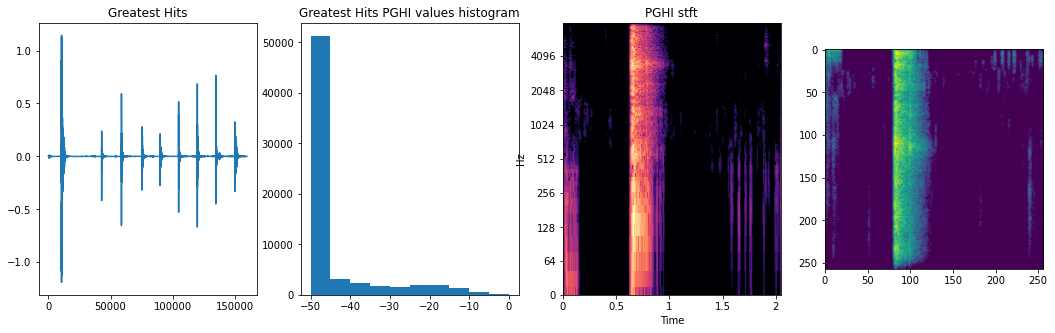

In [16]:
audio_file = '/home/purnima/appdir/Github/DATA/GreatestHitsDB/vis-data-256/2015-02-16-16-49-06_denoised.wav'
display_audio_stats(audio_file, 'Greatest Hits', start_sec=0, end_sec=10)

original length of audio =  639840
Length of audio for stft =  32000


(1, 257, 256)
original length of audio =  639840
Length of audio for stft =  32000


(1, 257, 256)


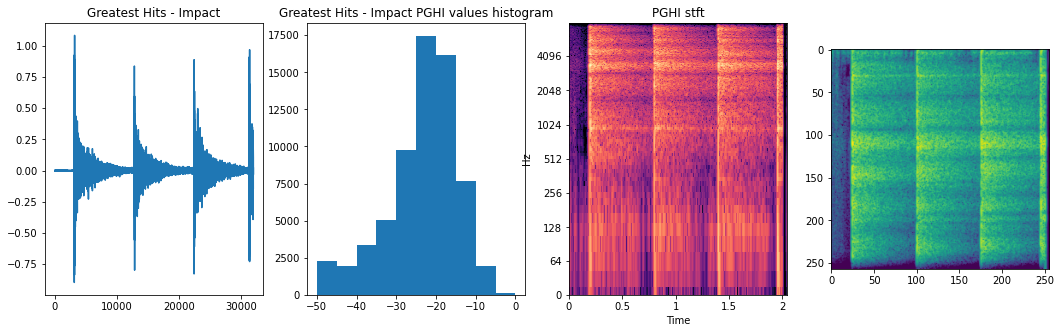

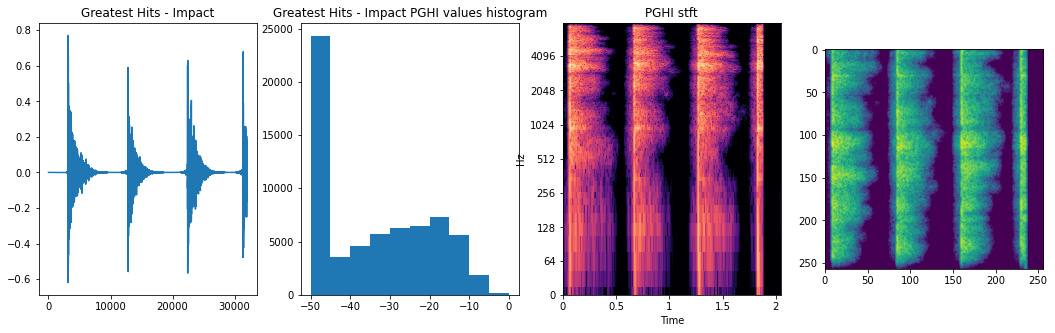

In [17]:
audio_file = '/home/purnima/appdir/Github/DATA/GreatestHitsDB/vis-data-256/2015-10-03-14-00-26-777_denoised.wav'
display_audio_stats(audio_file, 'Greatest Hits - Impact', start_sec=1, end_sec=3)

display_audio_stats(audio_file, 'Greatest Hits - Impact', start_sec=1, end_sec=3, reduce_noise=True)

original length of audio =  639840
Length of audio for stft =  48000


(1, 257, 256)
original length of audio =  639840
Length of audio for stft =  48000


(1, 257, 256)


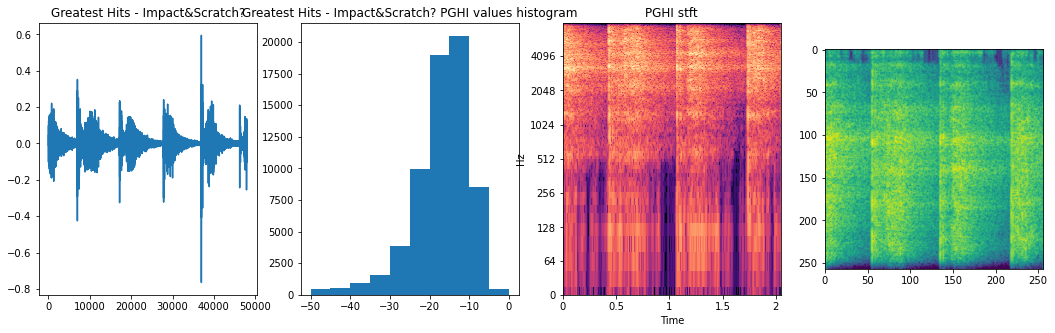

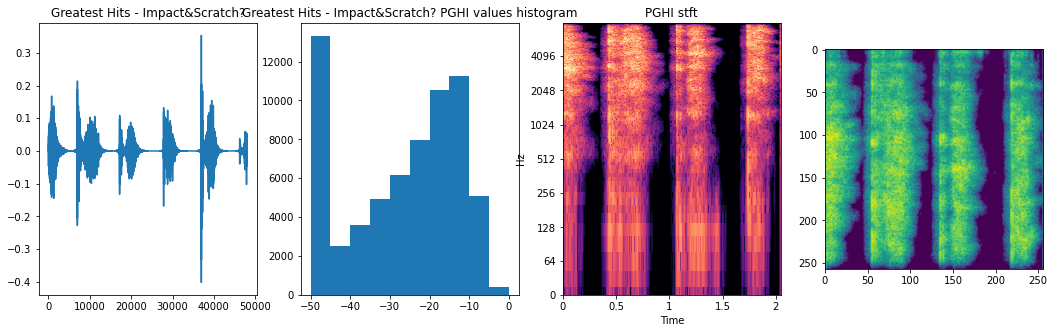

In [18]:
audio_file = '/home/purnima/appdir/Github/DATA/GreatestHitsDB/vis-data-256/2015-10-03-14-00-26-777_denoised.wav'
display_audio_stats(audio_file, 'Greatest Hits - Impact&Scratch?', start_sec=25, end_sec=28)

display_audio_stats(audio_file, 'Greatest Hits - Impact&Scratch?', start_sec=25, end_sec=28, reduce_noise=True)

# Can Spectral Centroid be used to identify if there are events in an audio sample of len(x)?

[Text(0.5, 1.0, 'log Power spectrogram')]

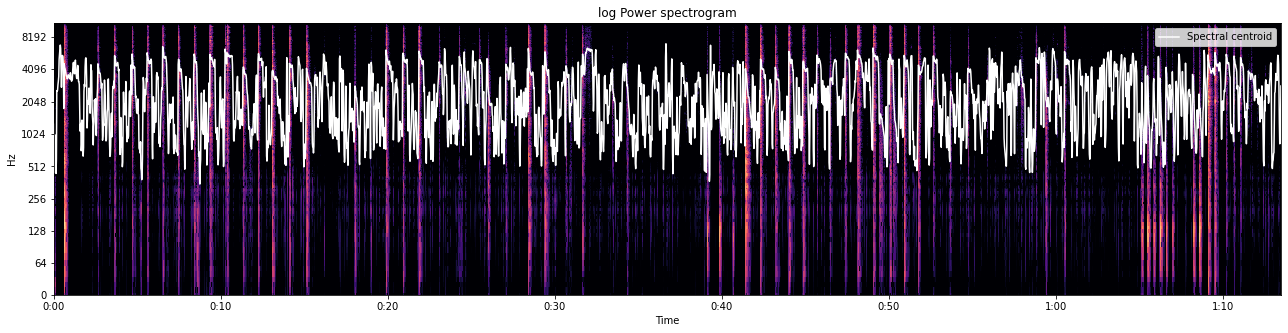

In [84]:
audio_file = '/home/purnima/appdir/Github/DATA/GreatestHitsDB/vis-data-256/2015-02-16-16-49-06_denoised.wav'
y, sr = librosa.load(audio_file)
# y=y[int(16000*1.2):int(16000*1.3)]
cent = librosa.feature.spectral_centroid(y=y, sr=sr)
times = librosa.times_like(cent)

S, phase = librosa.magphase(librosa.stft(y=y))
librosa.feature.spectral_centroid(S=S)

fig, ax = plt.subplots(figsize=(22,5))
librosa.display.specshow(librosa.amplitude_to_db(S, ref=np.max),
                         y_axis='log', x_axis='time', ax=ax,sr=sr)
ax.plot(times, cent.T, label='Spectral centroid', color='w')
ax.legend(loc='upper right')
ax.set(title='log Power spectrogram')